In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyedflib
import seaborn
import numpy as np
import mne
import neurokit2 as nk
import os
import seaborn as sns
from scipy.fftpack import fft
from scipy.interpolate import interp1d
from scipy import signal
import heart_functions
import importlib

In [4]:
save_data = r'/home/nataly/mnt/dataFrom142/sleep_project/ANPHY/EPCTL01/Results/HRVfeatures'
os.makedirs(save_data, exist_ok=True)

In [5]:
file_path_1 = '/home/nataly/mnt/dataFrom142/sleep_project/ANPHY/EPCTL01/EPCTL01.edf'

channels_of_interest = ['ECG1', 'ECG2']

data_of_interest = {}

with pyedflib.EdfReader(file_path_1) as edf_reader:
    channel_labels = edf_reader.getSignalLabels()
    print("Channel labels:", channel_labels)

    indices_of_interest = [channel_labels.index(ch) for ch in channels_of_interest if ch in channel_labels]

    for ch, idx in zip(channels_of_interest, indices_of_interest):
        signal_data = edf_reader.readSignal(idx)
        data_of_interest[ch] = signal_data

print("Extracted data from channels of interest:")
for ch in data_of_interest:
    print(f"{ch}: {data_of_interest[ch].shape}")

Channel labels: ['Fp1-Ref', 'Fp2-Ref', 'F3-Ref', 'F4-Ref', 'C3-Ref', 'C4-Ref', 'P3-Ref', 'P4-Ref', 'O1-Ref', 'O2-Ref', 'F7-Ref', 'F8-Ref', 'T3-Ref', 'T4-Ref', 'T5-Ref', 'T6-Ref', 'FZ-Ref', 'CZ-Ref', 'PZ-Ref', 'SO1-Ref', 'SO2-Ref', 'F9-Ref', 'F10-Ref', 'ZY1', 'ZY2', 'T9-Ref', 'T10-Ref', 'P9-Ref', 'P10-Ref', 'AF7-Ref', 'AF3-Ref', 'F11', 'F5-Ref', 'F1-Ref', 'FT11', 'FT9-Ref', 'FT7-Ref', 'FC5-Ref', 'FC3-Ref', 'FC1-Ref', 'FCZ-Ref', 'C5-Ref', 'C1-Ref', 'TP11', 'TP9-Ref', 'TP7-Ref', 'CP3-Ref', 'CP1-Ref', 'P11', 'P5-Ref', 'P1-Ref', 'PO7-Ref', 'PO3-Ref', 'POZ-Ref', 'OZ-Ref', 'FPZ-Ref', 'AFZ-Ref', 'AF4-Ref', 'AF8-Ref', 'F2-Ref', 'F6-Ref', 'F12', 'FC2-Ref', 'FC4-Ref', 'FC6-Ref', 'FT8-Ref', 'FT10-Ref', 'FT12', 'C6-Ref', 'C2-Ref', 'CPZ-Ref', 'CP2-Ref', 'CP4-Ref', 'CP6-Ref', 'TP8-Ref', 'TP10-Ref', 'TP12', 'P2-Ref', 'P6-Ref', 'P12', 'PO4-Ref', 'PO8-Ref', 'ChEMG1', 'ChEMG2', 'RLEG-', 'RLEG+', 'LLEG-', 'LLEG+', 'EOG2', 'EOG1', 'ECG2', 'ECG1', 'CP5']
Extracted data from channels of interest:
ECG1: (2873

In [20]:
file_path = '/home/nataly/mnt/dataFrom142/sleep_project/ANPHY/EPCTL01/state_assignment_results.csv'
df = pd.read_csv(file_path)
print(df.head())

   Unnamed: 0             0              1             2             3  \
0           0  0.000000e+00  1.552000e-139  0.000000e+00  0.000000e+00   
1           1  7.454628e-12   4.376564e-01  8.650758e-37  5.673477e-19   
2           2  3.051243e-10   9.235379e-01  1.462837e-28  2.726187e-15   
3           3  5.925548e-10   9.724487e-01  1.161690e-30  2.929103e-17   
4           4  7.789141e-09   9.836128e-01  7.832964e-23  1.100999e-13   

              4         5             6             7             8  \
0  0.000000e+00  0.998735  1.159105e-03  0.000000e+00  0.000000e+00   
1  7.345082e-09  0.466198  1.678012e-03  3.896297e-08  3.007314e-32   
2  5.844999e-07  0.010888  1.139187e-04  3.795494e-04  7.398899e-22   
3  8.601045e-07  0.000328  5.250472e-06  4.233618e-04  3.851640e-20   
4  1.867775e-05  0.000001  5.050703e-08  2.727220e-03  6.214202e-18   

              9        10  hidden_states hidden_states_mapped labels     time  \
0  2.928567e-40  0.000106              5       

In [27]:
df = pd.read_csv(file_path, usecols=['hidden_states', 'hidden_states_mapped' ,'time_from_onset', 'patient'])
df = df[df['patient'] == "EPCTL01"] # change here for selected different patient
df.rename(columns={'hidden_states': 'number', 'hidden_states_mapped': 'label','time_from_onset': 'start_time'}, inplace=True)
print(df.head())

   number label  start_time  patient
0       5     W         0.0  EPCTL01
1       1     R         4.0  EPCTL01
2       1     R         8.0  EPCTL01
3       1     R        12.0  EPCTL01
4       1     R        16.0  EPCTL01


In [30]:
print(df['number'].unique())
print(df['label'].unique())


[ 5  1  9  7  0  4 10  8  3  2  6]
['W' 'R' 'N1' 'N2' 'N3']


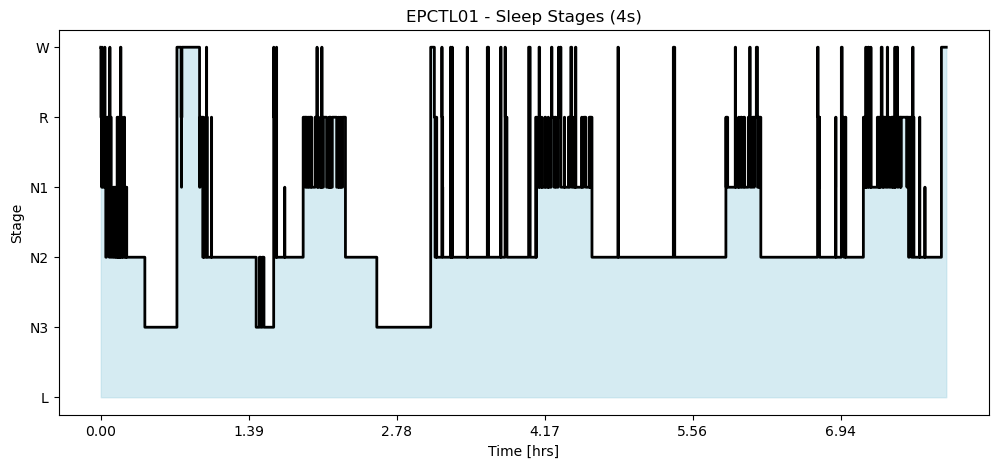

In [29]:
order = ['L', 'N3', 'N2', 'N1', 'R', 'W']
stage_map = {label: i for i, label in enumerate(order)}
df['y_stage'] = df['label'].map(stage_map)
df = df.sort_values(by='start_time')
df['duration'] = 4

x_points, y_points = [], []
for (start_time, duration, y_stage), next_stage in zip(
    df[['start_time', 'duration', 'y_stage']].values, 
    df['y_stage'].values[1:].tolist() + [None]  
):
    x_points.extend([start_time, start_time + duration])
    y_points.extend([y_stage, y_stage])

    if next_stage is not None and next_stage != y_stage:
        x_points.append(start_time + duration)
        y_points.append(next_stage)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x_points, y_points, drawstyle='steps-post', color='black', linewidth=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/3600:.2f}'))
ax.set_yticks(range(len(order)))
ax.set_yticklabels(order)

ax.set_xlabel("Time [hrs]")
ax.set_ylabel("Stage")
ax.set_title(f"{df['patient'].iloc[0]} - Sleep Stages (4s)")
ax.fill_between(x_points, min(stage_map.values()), y_points, step="post", color='lightblue', alpha=0.5)
plt.savefig(os.path.join(save_data, "hipnogram_4s_EPCTL01.png"), dpi=300, bbox_inches='tight')
plt.show()

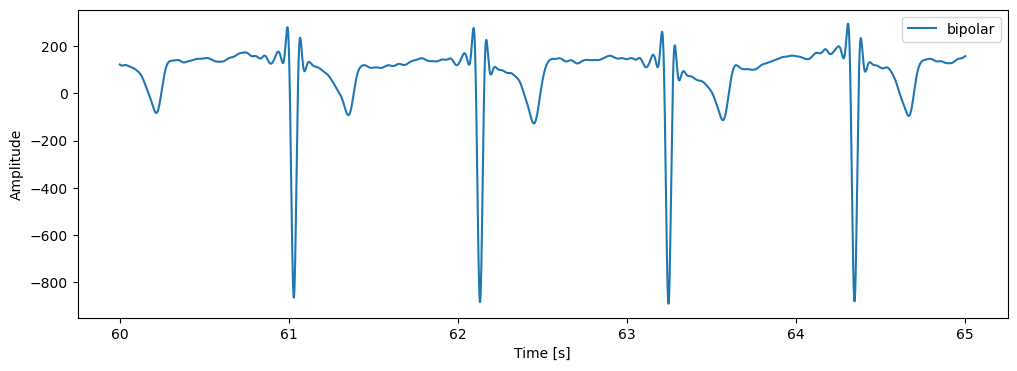

In [101]:
fs =1000
ECG1 = data_of_interest["ECG1"]
ECG2 = data_of_interest["ECG2"]

ECG1 = nk.signal_filter(
    ECG1,
    sampling_rate=fs,
    #lowcut=0.5,      # Hz
    highcut=20,      # Hz
    method="butterworth",
    order=4
)

ECG2 = nk.signal_filter(
    ECG2,
    sampling_rate=fs,
    #lowcut=0.5,      # Hz
    highcut=20,      # Hz
    method="butterworth",
    order=4
)

bipolar = ECG1 - ECG2
bipolar_emphasized = np.diff(bipolar) ** 2

start_plot = 60 #seconds
end_plot = 65 #seconds

time = np.linspace(start_plot, end_plot, int(end_plot * fs) - int(start_plot * fs))
segment = bipolar[int(start_plot * fs):int(end_plot * fs)]

plt.figure(figsize=(12, 4))
plt.plot(time, segment, label="bipolar")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [250]:
#ECG = -bipolar #for this patient is upside down
ECG = bipolar_emphasized

In [185]:
segment_duration = 90# segundos
samples_per_segment = segment_duration * fs

# Por ejemplo, cortamos el primer minuto:
ecg_segment = ECG[:samples_per_segment]

rpeaks, rpeaks_times, ibi, ibi_times = heart_functions.detect_rpeaks_and_compute_ibi(ecg_segment, fs=fs, refractory_period_bpm=220, adjust=True, search_window=200)


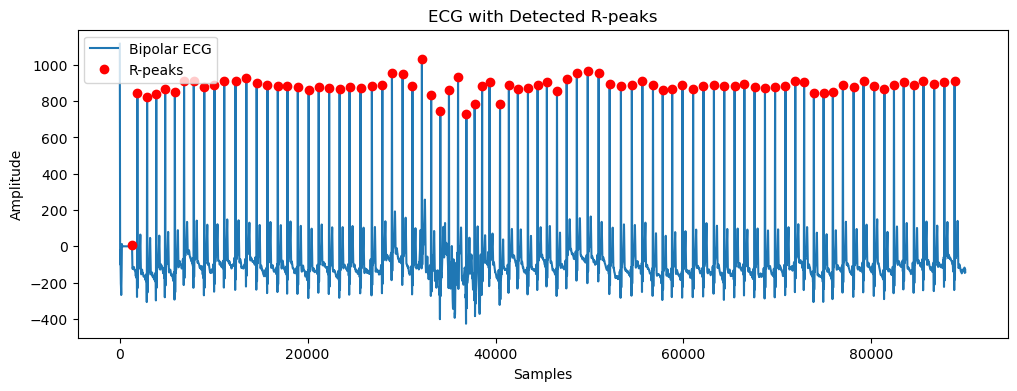

In [186]:
plt.figure(figsize=(12, 4))
plt.plot(ecg_segment, label="Bipolar ECG")
plt.plot(rpeaks, ecg_segment[rpeaks], 'ro', label="R-peaks")
plt.title("ECG with Detected R-peaks")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [ ]:
rpeaks, rpeaks_times, ibi, ibi_times = heart_functions.detect_rpeaks_and_compute_ibi(ECG, fs=fs, refractory_period_bpm=220, adjust=True, search_window=200)

/home/nataly/anaconda3/envs/prepro/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


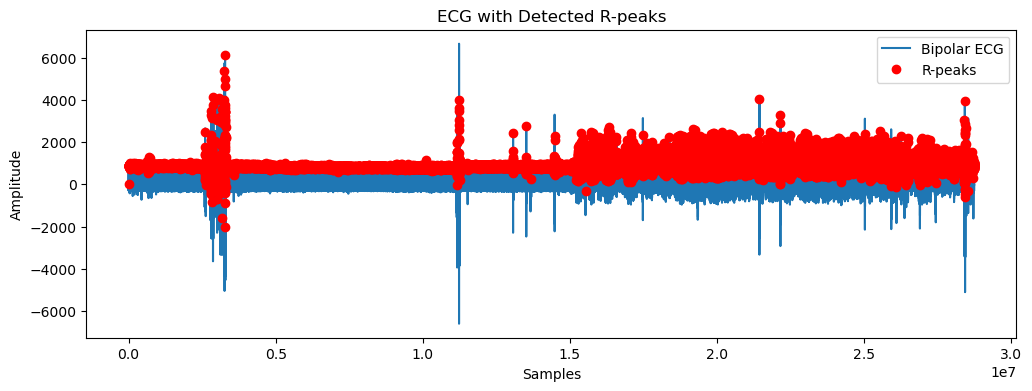

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(ECG, label="Bipolar ECG")  #
plt.plot(rpeaks, ECG[rpeaks], 'ro', label="R-peaks")  
plt.title("ECG with Detected R-peaks")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [215]:
rmssd_vals, rmssd_times = heart_functions.continuous_rmssd(
    rr_timestamps=rpeaks_times,
    window_sec=12,  
    min_beats=8,
    parallel=True,
    n_jobs = -1
)

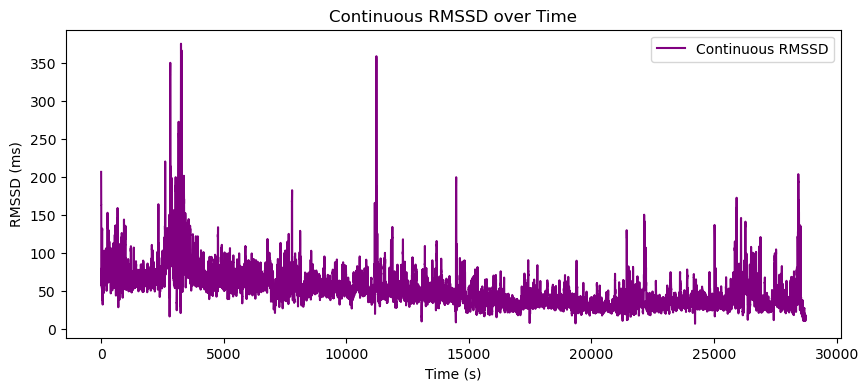

In [216]:
plt.figure(figsize=(10, 4))
plt.plot(rmssd_times, rmssd_vals, label="Continuous RMSSD", color="purple")
plt.xlabel("Time (s)")
plt.ylabel("RMSSD (ms)")
plt.title("Continuous RMSSD over Time")
plt.legend()
plt.show()

In [219]:
new_time_rmssd, new_rmssd = heart_functions.uniform_interpolation(rmssd_vals, rmssd_times, new_fs=1, start_time=0)

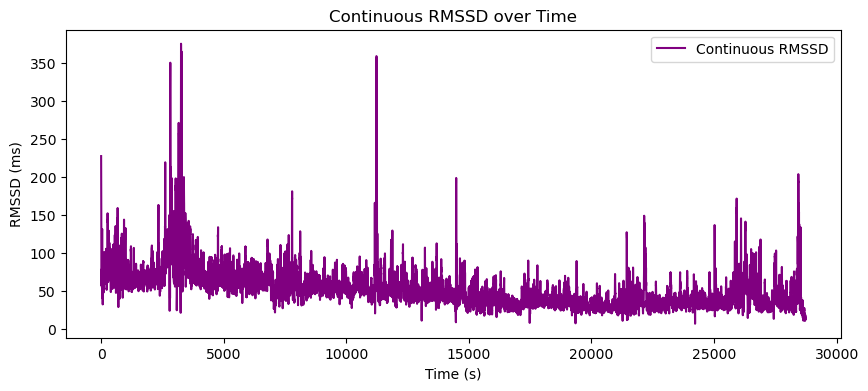

In [220]:
plt.figure(figsize=(10, 4))
plt.plot(new_time_rmssd, new_rmssd, label="Continuous RMSSD", color="purple")
plt.xlabel("Time (s)")
plt.ylabel("RMSSD (ms)")
plt.title("Continuous RMSSD over Time")
plt.legend()
plt.show()

In [244]:
importlib.reload(heart_functions)

<module 'heart_functions' from '/home/nataly/mnt/dataFrom103/sleep_project/ANPHY/EPCTL01/heart_functions.py'>

In [245]:
ibi_series, ibi_v = heart_functions.uniform_interpolation(ibi, ibi_times, new_fs=4, start_time=0)
t, lf_sig, hf_sig = heart_functions.separate_hr_bands(ibi_series, ibi_v, fs=4)  # Fs = 4Hz después de interpolar

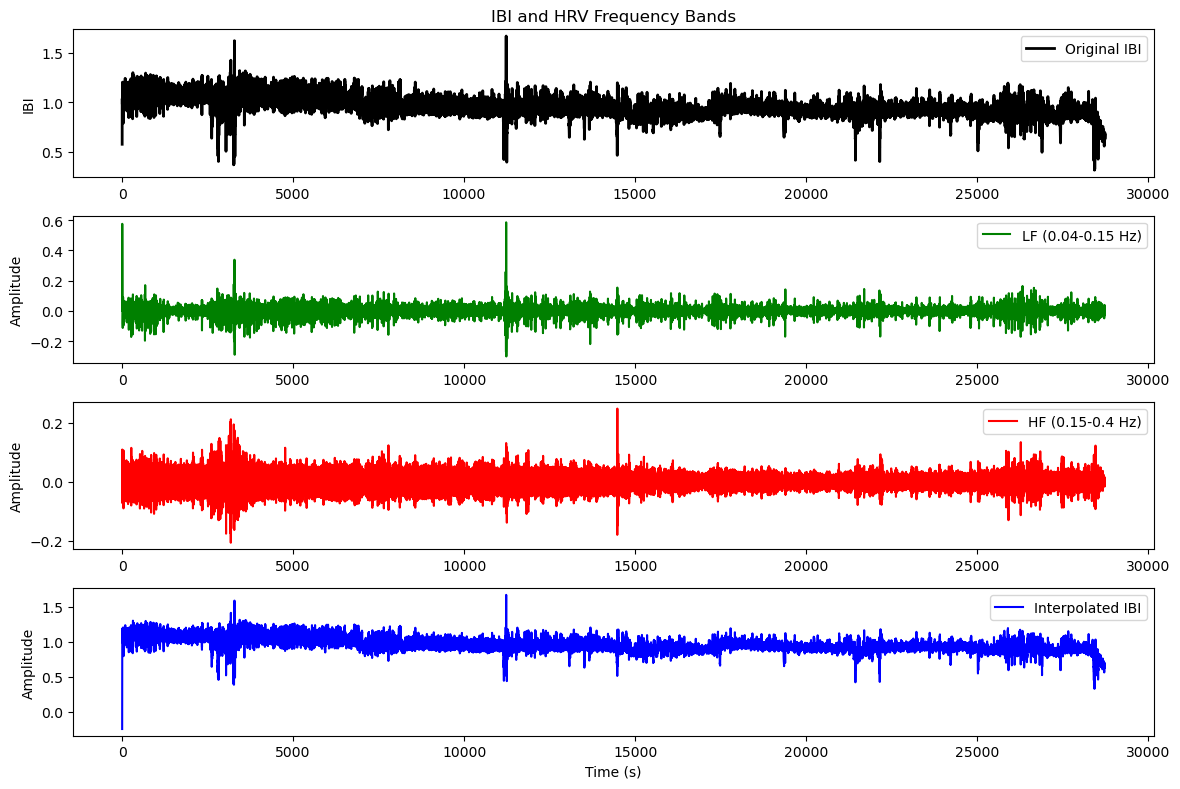

In [249]:
plt.figure(figsize=(12, 8))

# 1. Raw IBI series vs interpolated
plt.subplot(4, 1, 1)
plt.plot(ibi_times, ibi, label="Original IBI", color="black", linewidth=2)

plt.ylabel("IBI")
plt.title("IBI and HRV Frequency Bands")
plt.legend(loc="upper right")

# 2. LF band
plt.subplot(4, 1, 2)
plt.plot(t, lf_sig, label="LF (0.04-0.15 Hz)", color="green")
plt.ylabel("Amplitude")
plt.legend(loc="upper right")

# 3. HF band
plt.subplot(4, 1, 3)
plt.plot(t, hf_sig, label="HF (0.15-0.4 Hz)", color="red")
plt.ylabel("Amplitude")
plt.legend(loc="upper right")

# 4. Placeholder: por ejemplo, la suma o comparación de bandas
plt.subplot(4, 1, 4)
plt.plot(ibi_series, ibi_v, label="Interpolated IBI", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

